## Run a single example of the calibration for a certain set of parameters

In [1]:
include("ms_calibration.jl")
import PyPlot
const plt = PyPlot;

detuning = 10e3
pi_time = 5e-6
initial_guess = [detuning*0.8, pi_time*0.8]
tspan_ideal = 0:0.1:200

N = 50
tspan_experiment = 0:10:100

res = ms_calibration(detuning, pi_time, initial_guess, N, tspan_ideal, tspan_experiment)

ideal = res["ideal_curve"]
ideal_fit_params = res["ideal_fit_params"]
experimental = res["experimental_data"]
learned = res["learned_curve"]
learned_fit_params = res["learned_fit_params"]

mean_error = mean(abs.(ideal_fit_params - learned_fit_params))
relative_error = mean_error / mean(ideal_fit_params)

 10.460565 seconds (30.53 M allocations: 2.072 GiB, 4.97% gc time, 48.63% compilation time)
  0.179826 seconds (2.42 M allocations: 84.902 MiB, 17.64% gc time, 14.53% compilation time)
  0.155253 seconds (2.62 M allocations: 91.851 MiB, 8.06% compilation time)
  0.182516 seconds (2.68 M allocations: 93.708 MiB, 26.91% gc time)
  0.030773 seconds (548.80 k allocations: 19.241 MiB)
  0.028927 seconds (551.05 k allocations: 19.319 MiB)
  0.036348 seconds (643.05 k allocations: 22.540 MiB)
  0.036286 seconds (643.05 k allocations: 22.540 MiB)
  0.072185 seconds (874.18 k allocations: 30.631 MiB, 42.28% gc time)
  0.042822 seconds (871.94 k allocations: 30.552 MiB)
  0.072495 seconds (1.35 M allocations: 47.362 MiB)
  0.110404 seconds (1.35 M allocations: 47.284 MiB, 26.35% gc time)
  0.060396 seconds (1.16 M allocations: 40.764 MiB)
  0.059784 seconds (1.15 M allocations: 40.293 MiB)
  0.073474 seconds (1.32 M allocations: 46.341 MiB)
  0.087963 seconds (1.32 M allocations: 46.105 MiB, 27.

  0.168890 seconds (2.42 M allocations: 84.675 MiB, 14.50% gc time)
  0.119744 seconds (2.42 M allocations: 84.675 MiB)
  0.146709 seconds (2.42 M allocations: 84.675 MiB, 16.35% gc time)
  0.129968 seconds (2.42 M allocations: 84.675 MiB)
  0.152608 seconds (2.42 M allocations: 84.675 MiB, 20.23% gc time)
  0.155449 seconds (2.42 M allocations: 84.675 MiB, 15.37% gc time)
  0.125602 seconds (2.42 M allocations: 84.675 MiB)
  0.163406 seconds (2.42 M allocations: 84.675 MiB, 14.69% gc time)
  0.123727 seconds (2.42 M allocations: 84.675 MiB)
  0.143870 seconds (2.42 M allocations: 84.596 MiB, 16.58% gc time)
  0.139590 seconds (2.42 M allocations: 84.596 MiB)
  0.138907 seconds (2.42 M allocations: 84.596 MiB, 17.28% gc time)
  0.165775 seconds (2.42 M allocations: 84.596 MiB, 14.43% gc time)
  0.284933 seconds (4.82 M allocations: 169.710 MiB, 8.26% gc time)


0.01866621877260175

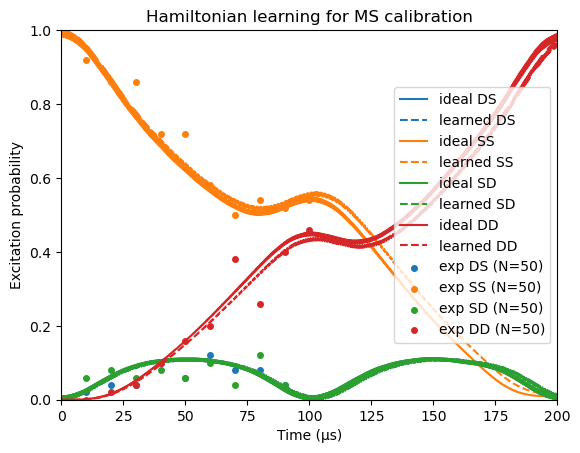

ideal fit parameters θ₁=10.0 kHz, θ₂=5.0 μs
learned fit parameters θ₁=9.8133 kHz, θ₂=5.1479 μs
fit parameters relative error=0.0187


In [2]:
plt.figure()
for state in keys(experimental[1])
    plt.plot(tspan_ideal, getindex.(ideal, state), "-", label="ideal $state")
    plt.plot(tspan_ideal, getindex.(learned, state), "--", label="learned $state", color=plt.gca().lines[end].get_color())
    plt.scatter(tspan_experiment, getindex.(experimental, state), label="exp $state (N=$(N))", s=16, color=plt.gca().lines[end].get_color())
end

println("ideal fit parameters θ₁=$(round(ideal_fit_params[1]/1e3; digits=4)) kHz, θ₂=$(round(ideal_fit_params[2]*1e6; digits=4)) μs")
println("learned fit parameters θ₁=$(round(learned_fit_params[1]/1e3; digits=4)) kHz, θ₂=$(round(learned_fit_params[2]*1e6; digits=4)) μs")
println("fit parameters relative error=$(round(relative_error; digits=4))")

plt.title("Hamiltonian learning for MS calibration")
plt.xlim(tspan_ideal[1], tspan_ideal[end])
plt.ylim(0, 1)
plt.xlabel("Time (μs)")
plt.ylabel("Excitation probability")
plt.legend(loc="center right");

## Test the average error of the technique as a function of N

In [3]:
include("ms_calibration.jl")

n_repetitions = 20
n_shots_list = [5, 10, 25, 50, 100, 250, 500, 1000]

tspan_ideal = 0:0.1:200
tspan_experiment = 0:10:100

relative_error_results = Dict()
fidelities = Dict()
for n_shots in n_shots_list 
    relative_error_results[n_shots] = []
    fidelities[n_shots] = []
    for i = 1:n_repetitions
        actual_detuning = 10e3
        actual_pi_time = 5e-6
        initial_guess = [actual_detuning*0.8, actual_pi_time*0.8]
        res = ms_calibration(actual_detuning, actual_pi_time, initial_guess, n_shots, tspan_ideal, tspan_experiment)

        ideal = res["ideal_curve"]
        ideal_fit_params = res["ideal_fit_params"]
        experimental = res["experimental_data"]
        learned = res["learned_curve"]
        learned_fit_params = res["learned_fit_params"]

        # calculate relative error in learned fit parameters
        mean_error = mean(abs.(ideal_fit_params - learned_fit_params))
        relative_error = mean_error / mean(ideal_fit_params)
        push!(relative_error_results[n_shots], relative_error)
        
        # calculate the resulting error in MS-gate fidelity
        learned_detuning = learned_fit_params[1]
        learned_pi_time = learned_fit_params[2]
        fidelity = ms_fidelity(actual_detuning, actual_pi_time, learned_detuning, learned_pi_time)
        push!(fidelities[n_shots], fidelity)
    end
end

  0.260938 seconds (4.80 M allocations: 169.003 MiB, 12.26% gc time)
  0.155958 seconds (2.42 M allocations: 84.596 MiB, 18.66% gc time)
  0.169220 seconds (2.62 M allocations: 91.587 MiB, 18.14% gc time)
  0.137076 seconds (2.68 M allocations: 93.708 MiB)
  0.036770 seconds (548.80 k allocations: 19.241 MiB)
  0.031237 seconds (551.05 k allocations: 19.319 MiB)
  0.060403 seconds (643.05 k allocations: 22.540 MiB, 44.07% gc time)
  0.032044 seconds (643.05 k allocations: 22.540 MiB)
  0.041341 seconds (874.18 k allocations: 30.631 MiB)
  0.044383 seconds (871.94 k allocations: 30.552 MiB)
  0.074808 seconds (1.35 M allocations: 47.362 MiB)
  0.098703 seconds (1.35 M allocations: 47.284 MiB, 26.63% gc time)
  0.056704 seconds (1.16 M allocations: 40.764 MiB)
  0.062089 seconds (1.15 M allocations: 40.293 MiB)
  0.095176 seconds (1.32 M allocations: 46.341 MiB, 25.65% gc time)
  0.061539 seconds (1.32 M allocations: 46.105 MiB)
  0.083397 seconds (1.54 M allocations: 53.804 MiB)
  0.106

  0.085348 seconds (1.54 M allocations: 53.804 MiB)
  0.103097 seconds (1.55 M allocations: 54.196 MiB, 23.71% gc time)
  0.088454 seconds (1.59 M allocations: 55.767 MiB)
  0.109912 seconds (1.56 M allocations: 54.589 MiB, 22.08% gc time)
  0.093211 seconds (1.81 M allocations: 63.230 MiB)
  0.098051 seconds (1.78 M allocations: 62.444 MiB)
  0.128141 seconds (1.95 M allocations: 68.179 MiB, 19.66% gc time)
  0.103797 seconds (1.92 M allocations: 67.157 MiB)
  0.132488 seconds (1.93 M allocations: 67.629 MiB, 18.83% gc time)
  0.093735 seconds (1.85 M allocations: 64.879 MiB)
  0.162620 seconds (2.21 M allocations: 77.448 MiB, 14.88% gc time)
  0.098554 seconds (2.00 M allocations: 69.907 MiB)
  0.228744 seconds (4.07 M allocations: 142.411 MiB, 10.56% gc time)
  0.174003 seconds (2.67 M allocations: 93.551 MiB, 13.99% gc time)
  0.251797 seconds (4.02 M allocations: 140.761 MiB, 9.69% gc time)
  0.115393 seconds (2.18 M allocations: 76.270 MiB)
  0.421075 seconds (7.19 M allocations:

  0.162123 seconds (2.49 M allocations: 87.110 MiB, 15.07% gc time)
  0.131049 seconds (2.49 M allocations: 87.110 MiB)
  0.165835 seconds (2.49 M allocations: 87.110 MiB, 14.88% gc time)
  0.173232 seconds (2.48 M allocations: 86.953 MiB, 13.77% gc time)
  0.124636 seconds (2.48 M allocations: 86.953 MiB)
  0.166391 seconds (2.48 M allocations: 86.953 MiB, 15.04% gc time)
  0.136310 seconds (2.49 M allocations: 87.110 MiB)
  0.281741 seconds (4.93 M allocations: 173.559 MiB, 8.79% gc time)
  0.140302 seconds (2.34 M allocations: 81.763 MiB, 17.54% gc time)
  0.266112 seconds (4.80 M allocations: 169.003 MiB, 9.24% gc time)
  0.162128 seconds (2.42 M allocations: 84.596 MiB, 15.25% gc time)
  0.145795 seconds (2.62 M allocations: 91.587 MiB)
  0.156661 seconds (2.68 M allocations: 93.708 MiB, 15.40% gc time)
  0.029683 seconds (548.80 k allocations: 19.241 MiB)
  0.032026 seconds (551.05 k allocations: 19.319 MiB)
  0.035840 seconds (643.05 k allocations: 22.540 MiB)
  0.064167 seconds

  0.173821 seconds (2.47 M allocations: 86.638 MiB, 14.27% gc time)
  0.138113 seconds (2.47 M allocations: 86.638 MiB)
  0.160720 seconds (2.47 M allocations: 86.638 MiB, 15.05% gc time)
  0.130207 seconds (2.46 M allocations: 86.167 MiB)
  0.145465 seconds (2.46 M allocations: 86.167 MiB, 16.90% gc time)
  0.136436 seconds (2.47 M allocations: 86.638 MiB)
  0.149340 seconds (2.46 M allocations: 86.167 MiB, 16.80% gc time)
  0.156287 seconds (2.46 M allocations: 86.167 MiB, 15.45% gc time)
  0.132806 seconds (2.46 M allocations: 86.089 MiB)
  0.150736 seconds (2.46 M allocations: 86.167 MiB, 16.03% gc time)
  0.145559 seconds (2.46 M allocations: 86.167 MiB)
  0.159841 seconds (2.47 M allocations: 86.638 MiB, 15.24% gc time)
  0.131675 seconds (2.46 M allocations: 86.167 MiB)
  0.149964 seconds (2.47 M allocations: 86.638 MiB, 19.19% gc time)
  0.156565 seconds (2.46 M allocations: 86.167 MiB, 15.44% gc time)
  0.142227 seconds (2.46 M allocations: 86.167 MiB)
  0.171670 seconds (2.47

  0.161445 seconds (2.44 M allocations: 85.382 MiB, 15.78% gc time)
  0.148322 seconds (2.44 M allocations: 85.460 MiB)
  0.147961 seconds (2.44 M allocations: 85.382 MiB, 16.69% gc time)
  0.148557 seconds (2.44 M allocations: 85.382 MiB)
  0.158426 seconds (2.44 M allocations: 85.382 MiB, 16.53% gc time)
  0.159827 seconds (2.44 M allocations: 85.382 MiB, 16.14% gc time)
  0.135930 seconds (2.44 M allocations: 85.382 MiB)
  0.181431 seconds (2.44 M allocations: 85.460 MiB, 13.78% gc time)
  0.134111 seconds (2.44 M allocations: 85.382 MiB)
  0.169294 seconds (2.44 M allocations: 85.382 MiB, 14.75% gc time)
  0.126003 seconds (2.44 M allocations: 85.460 MiB)
  0.144050 seconds (2.44 M allocations: 85.382 MiB, 17.01% gc time)
  0.132617 seconds (2.44 M allocations: 85.382 MiB)
  0.154194 seconds (2.44 M allocations: 85.382 MiB, 16.98% gc time)
  0.155806 seconds (2.44 M allocations: 85.382 MiB, 15.60% gc time)
  0.123654 seconds (2.44 M allocations: 85.382 MiB)
  0.169612 seconds (2.44

  0.124167 seconds (2.39 M allocations: 83.732 MiB)
  0.156443 seconds (2.40 M allocations: 84.125 MiB, 16.03% gc time)
  0.132689 seconds (2.39 M allocations: 83.575 MiB)
  0.163099 seconds (2.39 M allocations: 83.653 MiB, 15.37% gc time)
  0.162484 seconds (2.39 M allocations: 83.575 MiB)
  0.162485 seconds (2.39 M allocations: 83.575 MiB, 17.04% gc time)
  0.145403 seconds (2.39 M allocations: 83.575 MiB)
  0.168348 seconds (2.39 M allocations: 83.732 MiB, 16.64% gc time)
  0.166751 seconds (2.40 M allocations: 83.889 MiB, 14.89% gc time)
  0.127231 seconds (2.38 M allocations: 83.418 MiB)
  0.160502 seconds (2.40 M allocations: 83.889 MiB, 15.48% gc time)
  0.142052 seconds (2.39 M allocations: 83.653 MiB)
  0.172412 seconds (2.39 M allocations: 83.653 MiB, 14.60% gc time)
  0.135314 seconds (2.39 M allocations: 83.732 MiB)
  0.174089 seconds (2.39 M allocations: 83.732 MiB, 15.23% gc time)
  0.138995 seconds (2.39 M allocations: 83.653 MiB)
  0.163378 seconds (2.39 M allocations: 

  0.101231 seconds (1.85 M allocations: 64.879 MiB)
  0.150423 seconds (2.21 M allocations: 77.448 MiB, 18.19% gc time)
  0.108059 seconds (2.21 M allocations: 77.526 MiB)
  0.491478 seconds (7.15 M allocations: 250.420 MiB, 10.47% gc time)
  0.272910 seconds (4.02 M allocations: 140.761 MiB, 9.22% gc time)
  0.131909 seconds (2.67 M allocations: 93.551 MiB)
  0.139438 seconds (2.18 M allocations: 76.270 MiB, 17.71% gc time)
  0.430250 seconds (7.19 M allocations: 251.598 MiB, 5.83% gc time)
  0.168688 seconds (2.68 M allocations: 93.865 MiB, 15.26% gc time)
  0.485996 seconds (7.18 M allocations: 251.520 MiB, 10.78% gc time)
  0.116867 seconds (2.30 M allocations: 80.511 MiB)
  0.170846 seconds (2.54 M allocations: 88.916 MiB, 14.97% gc time)
  0.126539 seconds (2.56 M allocations: 89.623 MiB)
  0.154979 seconds (2.47 M allocations: 86.638 MiB, 16.29% gc time)
  0.137236 seconds (2.66 M allocations: 93.315 MiB)
  0.146275 seconds (2.44 M allocations: 85.460 MiB, 17.10% gc time)
  0.13

  0.592809 seconds (9.99 M allocations: 349.710 MiB, 8.69% gc time)
  0.297487 seconds (4.80 M allocations: 168.097 MiB, 8.61% gc time)
  0.416747 seconds (7.19 M allocations: 251.598 MiB, 12.24% gc time)
  0.199276 seconds (2.87 M allocations: 100.385 MiB, 12.54% gc time)
  0.277853 seconds (4.72 M allocations: 165.269 MiB, 9.07% gc time)
  0.121800 seconds (2.44 M allocations: 85.539 MiB)
  0.153393 seconds (2.26 M allocations: 79.097 MiB, 16.99% gc time)
  0.163638 seconds (2.95 M allocations: 103.292 MiB)
  0.176401 seconds (2.59 M allocations: 90.566 MiB, 14.13% gc time)
  0.206337 seconds (3.08 M allocations: 107.690 MiB, 12.11% gc time)
  0.131485 seconds (2.56 M allocations: 89.623 MiB)
  0.163084 seconds (2.40 M allocations: 83.968 MiB, 15.44% gc time)
  0.137526 seconds (2.71 M allocations: 94.808 MiB)
  0.153200 seconds (2.52 M allocations: 88.288 MiB, 16.55% gc time)
  0.139958 seconds (2.42 M allocations: 84.832 MiB)
  0.187077 seconds (2.60 M allocations: 91.037 MiB, 21.1

  0.199087 seconds (2.60 M allocations: 90.880 MiB, 13.18% gc time)
  0.147102 seconds (2.53 M allocations: 88.602 MiB)
  0.218543 seconds (2.59 M allocations: 90.723 MiB, 13.93% gc time)
  0.195600 seconds (2.55 M allocations: 89.231 MiB)
  0.186637 seconds (2.60 M allocations: 90.959 MiB, 14.20% gc time)
  0.197906 seconds (2.55 M allocations: 89.466 MiB, 13.37% gc time)
  0.158076 seconds (2.59 M allocations: 90.802 MiB)
  0.171123 seconds (2.58 M allocations: 90.330 MiB, 15.49% gc time)
  0.144913 seconds (2.52 M allocations: 88.367 MiB)
  0.174842 seconds (2.59 M allocations: 90.723 MiB, 14.72% gc time)
  0.163586 seconds (2.59 M allocations: 90.802 MiB)
  0.186319 seconds (2.60 M allocations: 90.880 MiB, 13.84% gc time)
  0.171605 seconds (2.59 M allocations: 90.566 MiB, 15.01% gc time)
  0.176828 seconds (2.58 M allocations: 90.330 MiB)
  0.186415 seconds (2.59 M allocations: 90.802 MiB, 14.53% gc time)
  0.141184 seconds (2.59 M allocations: 90.802 MiB)
  0.173189 seconds (2.59

  0.081927 seconds (1.56 M allocations: 54.589 MiB)
  0.124474 seconds (1.81 M allocations: 63.230 MiB, 20.81% gc time)
  0.104921 seconds (1.78 M allocations: 62.444 MiB)
  0.122088 seconds (1.95 M allocations: 68.179 MiB)
  0.123769 seconds (1.92 M allocations: 67.157 MiB, 21.39% gc time)
  0.102361 seconds (1.93 M allocations: 67.629 MiB)
  0.128364 seconds (1.85 M allocations: 64.879 MiB, 20.12% gc time)
  0.114863 seconds (2.21 M allocations: 77.448 MiB)
  0.131659 seconds (2.00 M allocations: 69.907 MiB, 19.38% gc time)
  0.235440 seconds (4.07 M allocations: 142.411 MiB, 10.77% gc time)
  0.110709 seconds (2.18 M allocations: 76.270 MiB)
  0.429305 seconds (7.17 M allocations: 250.970 MiB, 11.99% gc time)
  0.135128 seconds (2.67 M allocations: 93.551 MiB)
  0.463880 seconds (7.19 M allocations: 251.598 MiB, 10.90% gc time)
  0.120178 seconds (2.31 M allocations: 80.983 MiB)
  0.159355 seconds (2.55 M allocations: 89.231 MiB, 16.21% gc time)
  0.138485 seconds (2.57 M allocation

  0.121400 seconds (1.93 M allocations: 67.629 MiB)
  0.133072 seconds (1.85 M allocations: 64.879 MiB, 20.12% gc time)
  0.114785 seconds (2.21 M allocations: 77.448 MiB)
  0.145642 seconds (2.00 M allocations: 69.907 MiB, 17.66% gc time)
  0.208138 seconds (4.07 M allocations: 142.411 MiB)
  0.166530 seconds (2.67 M allocations: 93.551 MiB, 15.60% gc time)
  0.253879 seconds (4.02 M allocations: 140.761 MiB, 10.12% gc time)
  0.123581 seconds (2.18 M allocations: 76.270 MiB)
  0.414738 seconds (7.19 M allocations: 251.598 MiB, 12.73% gc time)
  0.136169 seconds (2.31 M allocations: 80.983 MiB)
  0.164535 seconds (2.55 M allocations: 89.231 MiB, 17.98% gc time)
  0.164587 seconds (2.57 M allocations: 89.938 MiB, 15.39% gc time)
  0.139864 seconds (2.62 M allocations: 91.666 MiB)
  0.211085 seconds (3.13 M allocations: 109.497 MiB, 12.16% gc time)
  0.130060 seconds (2.44 M allocations: 85.382 MiB)
  0.160561 seconds (2.65 M allocations: 92.687 MiB, 16.11% gc time)
  0.145372 seconds (

  0.123704 seconds (2.31 M allocations: 80.983 MiB)
  0.164380 seconds (2.55 M allocations: 89.231 MiB, 16.32% gc time)
  0.141298 seconds (2.57 M allocations: 89.938 MiB)
  0.148210 seconds (2.48 M allocations: 86.717 MiB, 17.73% gc time)
  0.173042 seconds (2.62 M allocations: 91.666 MiB, 17.86% gc time)
  0.141441 seconds (2.67 M allocations: 93.551 MiB)
  0.189524 seconds (3.13 M allocations: 109.497 MiB, 13.40% gc time)
  0.129925 seconds (2.44 M allocations: 85.382 MiB)
  0.150711 seconds (2.47 M allocations: 86.560 MiB, 17.91% gc time)
  0.144971 seconds (2.43 M allocations: 84.989 MiB)
  0.150176 seconds (2.53 M allocations: 88.445 MiB, 17.24% gc time)
  0.136480 seconds (2.51 M allocations: 87.895 MiB)
  0.155097 seconds (2.49 M allocations: 87.345 MiB, 16.93% gc time)
  0.160961 seconds (2.46 M allocations: 86.089 MiB, 16.05% gc time)
  0.131285 seconds (2.55 M allocations: 89.309 MiB)
  0.166452 seconds (2.61 M allocations: 91.430 MiB, 15.66% gc time)
  0.158968 seconds (2.6

  0.126516 seconds (2.55 M allocations: 89.466 MiB)
  0.173433 seconds (2.59 M allocations: 90.802 MiB, 15.01% gc time)
  0.139249 seconds (2.47 M allocations: 86.560 MiB)
  0.153721 seconds (2.48 M allocations: 86.717 MiB, 17.29% gc time)
  0.145549 seconds (2.50 M allocations: 87.424 MiB)
  0.149430 seconds (2.48 M allocations: 86.717 MiB, 17.52% gc time)
  0.130432 seconds (2.41 M allocations: 84.518 MiB)
  0.148578 seconds (2.45 M allocations: 85.774 MiB, 17.96% gc time)
  0.172226 seconds (2.61 M allocations: 91.509 MiB, 15.14% gc time)
  0.117101 seconds (2.43 M allocations: 85.067 MiB)
  0.158653 seconds (2.41 M allocations: 84.439 MiB, 16.46% gc time)
  0.117850 seconds (2.46 M allocations: 86.167 MiB)
  0.163499 seconds (2.45 M allocations: 85.696 MiB, 16.23% gc time)
  0.126176 seconds (2.40 M allocations: 84.125 MiB)
  0.162187 seconds (2.45 M allocations: 85.853 MiB, 16.35% gc time)
  0.133064 seconds (2.44 M allocations: 85.539 MiB)
  0.154824 seconds (2.44 M allocations: 

  0.128468 seconds (2.68 M allocations: 93.787 MiB)
  0.173921 seconds (2.60 M allocations: 91.194 MiB, 16.70% gc time)
  0.132957 seconds (2.62 M allocations: 91.666 MiB)
  0.163696 seconds (2.64 M allocations: 92.294 MiB, 15.75% gc time)
  0.135987 seconds (2.60 M allocations: 91.116 MiB)
  0.175632 seconds (2.56 M allocations: 89.623 MiB, 20.80% gc time)
  0.144141 seconds (2.60 M allocations: 91.194 MiB)
  0.152195 seconds (2.61 M allocations: 91.273 MiB, 17.41% gc time)
  0.171979 seconds (2.55 M allocations: 89.309 MiB, 17.91% gc time)
  0.127518 seconds (2.57 M allocations: 90.095 MiB)
  0.175642 seconds (2.62 M allocations: 91.587 MiB, 14.83% gc time)
  0.132819 seconds (2.63 M allocations: 92.137 MiB)
  0.162686 seconds (2.60 M allocations: 90.959 MiB, 16.08% gc time)
  0.137704 seconds (2.61 M allocations: 91.430 MiB)
  0.169407 seconds (2.61 M allocations: 91.430 MiB, 15.28% gc time)
  0.149991 seconds (2.57 M allocations: 89.859 MiB)
  0.163658 seconds (2.61 M allocations: 

  0.129898 seconds (2.54 M allocations: 88.838 MiB)
  0.175837 seconds (2.52 M allocations: 88.131 MiB, 21.43% gc time)
  0.131037 seconds (2.51 M allocations: 87.738 MiB)
  0.156046 seconds (2.54 M allocations: 89.074 MiB, 17.03% gc time)
  0.149457 seconds (2.53 M allocations: 88.681 MiB)
  0.159184 seconds (2.53 M allocations: 88.445 MiB, 17.01% gc time)
  0.148188 seconds (2.52 M allocations: 88.209 MiB)
  0.150098 seconds (2.51 M allocations: 87.895 MiB, 18.22% gc time)
  0.168887 seconds (2.52 M allocations: 88.209 MiB, 15.73% gc time)
  0.125865 seconds (2.54 M allocations: 88.838 MiB)
  0.162015 seconds (2.52 M allocations: 88.209 MiB, 16.67% gc time)
  0.129709 seconds (2.53 M allocations: 88.681 MiB)
  0.164087 seconds (2.53 M allocations: 88.524 MiB, 16.99% gc time)
  0.143659 seconds (2.53 M allocations: 88.524 MiB)
  0.159439 seconds (2.53 M allocations: 88.602 MiB, 16.71% gc time)
  0.131875 seconds (2.53 M allocations: 88.681 MiB)
  0.161604 seconds (2.52 M allocations: 

  0.174978 seconds (3.30 M allocations: 115.624 MiB)
  0.196224 seconds (3.31 M allocations: 115.938 MiB, 14.16% gc time)
  0.223234 seconds (3.31 M allocations: 115.860 MiB, 12.12% gc time)
  0.219500 seconds (3.30 M allocations: 115.703 MiB, 12.01% gc time)
  0.181586 seconds (3.31 M allocations: 115.938 MiB)
  0.196162 seconds (3.31 M allocations: 115.781 MiB, 13.84% gc time)
  0.203909 seconds (3.30 M allocations: 115.703 MiB, 12.98% gc time)
  0.182624 seconds (3.31 M allocations: 115.860 MiB)
  0.189597 seconds (3.31 M allocations: 115.860 MiB, 14.06% gc time)
  0.201211 seconds (3.30 M allocations: 115.703 MiB, 13.02% gc time)
  0.175675 seconds (3.31 M allocations: 116.017 MiB)
  0.200999 seconds (3.30 M allocations: 115.703 MiB, 13.95% gc time)
  0.216623 seconds (3.30 M allocations: 115.703 MiB, 12.46% gc time)
  0.219376 seconds (3.32 M allocations: 116.096 MiB, 12.11% gc time)
  0.164192 seconds (3.30 M allocations: 115.624 MiB)
  0.193249 seconds (3.31 M allocations: 115.7

  0.159967 seconds (2.54 M allocations: 89.074 MiB, 16.99% gc time)
  0.141099 seconds (2.55 M allocations: 89.152 MiB)
  0.154991 seconds (2.55 M allocations: 89.388 MiB, 17.80% gc time)
  0.168617 seconds (2.55 M allocations: 89.466 MiB, 15.89% gc time)
  0.125812 seconds (2.55 M allocations: 89.388 MiB)
  0.169143 seconds (2.55 M allocations: 89.309 MiB, 16.36% gc time)
  0.138798 seconds (2.55 M allocations: 89.309 MiB)
  0.167608 seconds (2.56 M allocations: 89.545 MiB, 16.29% gc time)
  0.142234 seconds (2.55 M allocations: 89.231 MiB)
  0.182845 seconds (2.55 M allocations: 89.309 MiB, 16.00% gc time)
  0.144374 seconds (2.55 M allocations: 89.231 MiB)
  0.158269 seconds (2.55 M allocations: 89.388 MiB, 17.09% gc time)
  0.132703 seconds (2.55 M allocations: 89.231 MiB)
  0.157197 seconds (2.55 M allocations: 89.309 MiB, 16.99% gc time)
  0.146802 seconds (2.55 M allocations: 89.309 MiB)
  0.214011 seconds (2.55 M allocations: 89.309 MiB, 17.67% gc time)
  0.169222 seconds (2.55

  0.172150 seconds (2.51 M allocations: 87.817 MiB)
  0.174376 seconds (2.47 M allocations: 86.481 MiB, 16.38% gc time)
  0.153994 seconds (2.46 M allocations: 86.246 MiB)
  0.164356 seconds (2.50 M allocations: 87.424 MiB, 18.56% gc time)
  0.149556 seconds (2.47 M allocations: 86.403 MiB)
  0.146808 seconds (2.49 M allocations: 87.031 MiB, 18.74% gc time)
  0.171895 seconds (2.48 M allocations: 86.953 MiB, 15.93% gc time)
  0.123953 seconds (2.49 M allocations: 87.188 MiB)
  0.180977 seconds (2.48 M allocations: 86.874 MiB, 15.51% gc time)
  0.137806 seconds (2.48 M allocations: 86.953 MiB)
  0.181808 seconds (2.49 M allocations: 87.267 MiB, 15.56% gc time)
  0.141305 seconds (2.48 M allocations: 86.796 MiB)
  0.196757 seconds (2.48 M allocations: 86.796 MiB, 14.17% gc time)
  0.133668 seconds (2.49 M allocations: 87.110 MiB)
  0.165632 seconds (2.50 M allocations: 87.660 MiB, 16.76% gc time)
  0.141817 seconds (2.48 M allocations: 86.953 MiB)
  0.179097 seconds (2.49 M allocations: 

  0.167080 seconds (2.42 M allocations: 84.753 MiB, 17.41% gc time)
  0.183466 seconds (2.46 M allocations: 86.089 MiB, 15.19% gc time)
  0.130585 seconds (2.41 M allocations: 84.518 MiB)
  0.186987 seconds (2.44 M allocations: 85.539 MiB, 15.10% gc time)
  0.127837 seconds (2.42 M allocations: 84.596 MiB)
  0.166630 seconds (2.44 M allocations: 85.617 MiB, 17.31% gc time)
  0.141264 seconds (2.42 M allocations: 84.753 MiB)
  0.170515 seconds (2.45 M allocations: 85.853 MiB, 16.74% gc time)
  0.119003 seconds (2.41 M allocations: 84.282 MiB)
  0.191722 seconds (2.41 M allocations: 84.518 MiB, 15.43% gc time)
  0.141659 seconds (2.42 M allocations: 84.753 MiB)
  0.149481 seconds (2.41 M allocations: 84.439 MiB)
  0.154494 seconds (2.41 M allocations: 84.518 MiB, 18.48% gc time)
  0.155593 seconds (2.42 M allocations: 84.675 MiB)
  0.144455 seconds (2.42 M allocations: 84.596 MiB, 19.57% gc time)
  0.149322 seconds (2.41 M allocations: 84.360 MiB)
  0.160954 seconds (2.41 M allocations: 

  0.150896 seconds (2.41 M allocations: 84.518 MiB)
  0.192284 seconds (2.43 M allocations: 85.067 MiB, 15.81% gc time)
  0.171529 seconds (2.41 M allocations: 84.518 MiB)
  0.163388 seconds (2.40 M allocations: 83.889 MiB, 17.22% gc time)
  0.152753 seconds (2.42 M allocations: 84.596 MiB)
  0.157744 seconds (2.42 M allocations: 84.753 MiB, 17.43% gc time)
  0.150344 seconds (2.41 M allocations: 84.518 MiB)
  0.202991 seconds (2.42 M allocations: 84.675 MiB, 13.71% gc time)
  0.201384 seconds (2.41 M allocations: 84.439 MiB)
  0.263305 seconds (2.42 M allocations: 84.596 MiB, 12.56% gc time)
  0.168817 seconds (2.41 M allocations: 84.439 MiB)
  0.172208 seconds (2.42 M allocations: 84.596 MiB, 16.78% gc time)
  0.146760 seconds (2.43 M allocations: 85.067 MiB)
  0.168643 seconds (2.42 M allocations: 84.675 MiB, 16.23% gc time)
  0.145672 seconds (2.42 M allocations: 84.596 MiB)
  0.181464 seconds (2.42 M allocations: 84.832 MiB, 16.90% gc time)
  0.139087 seconds (2.42 M allocations: 

  0.154806 seconds (2.48 M allocations: 86.953 MiB)
  0.159542 seconds (2.48 M allocations: 86.953 MiB, 17.79% gc time)
  0.169597 seconds (2.50 M allocations: 87.503 MiB)
  0.174359 seconds (2.48 M allocations: 86.953 MiB, 16.29% gc time)
  0.149541 seconds (2.49 M allocations: 87.031 MiB)
  0.166337 seconds (2.48 M allocations: 86.874 MiB, 17.10% gc time)
  0.158227 seconds (2.47 M allocations: 86.481 MiB)
  0.179346 seconds (2.50 M allocations: 87.503 MiB, 16.47% gc time)
  0.165799 seconds (2.48 M allocations: 86.953 MiB)
  0.188561 seconds (2.48 M allocations: 86.874 MiB, 16.14% gc time)
  0.233708 seconds (2.50 M allocations: 87.503 MiB)
  0.263643 seconds (2.48 M allocations: 86.953 MiB, 16.55% gc time)
  0.280294 seconds (2.48 M allocations: 86.953 MiB)
  0.291379 seconds (2.48 M allocations: 86.953 MiB, 14.82% gc time)
  0.218150 seconds (2.48 M allocations: 86.953 MiB)
  0.181885 seconds (2.49 M allocations: 87.031 MiB, 16.68% gc time)
  0.170299 seconds (2.48 M allocations: 

  0.130709 seconds (2.53 M allocations: 88.524 MiB)
  0.188624 seconds (2.53 M allocations: 88.524 MiB, 16.19% gc time)
  0.137824 seconds (2.53 M allocations: 88.524 MiB)
  0.193497 seconds (2.53 M allocations: 88.524 MiB, 15.35% gc time)
  0.139753 seconds (2.53 M allocations: 88.524 MiB)
  0.178895 seconds (2.53 M allocations: 88.524 MiB, 16.66% gc time)
  0.140819 seconds (2.53 M allocations: 88.524 MiB)
  0.182611 seconds (2.53 M allocations: 88.524 MiB, 16.37% gc time)
  0.173622 seconds (2.53 M allocations: 88.524 MiB)
  0.212468 seconds (2.53 M allocations: 88.524 MiB, 15.53% gc time)
  0.139887 seconds (2.53 M allocations: 88.524 MiB)
  0.199900 seconds (2.53 M allocations: 88.524 MiB, 15.30% gc time)
  0.148008 seconds (2.53 M allocations: 88.524 MiB)
  0.193545 seconds (2.53 M allocations: 88.524 MiB, 15.07% gc time)
  0.134239 seconds (2.53 M allocations: 88.524 MiB)
  0.173557 seconds (2.53 M allocations: 88.524 MiB, 15.97% gc time)
  0.130788 seconds (2.53 M allocations: 

  0.123028 seconds (2.50 M allocations: 87.424 MiB)
  0.161514 seconds (2.50 M allocations: 87.424 MiB, 17.23% gc time)
  0.136099 seconds (2.50 M allocations: 87.503 MiB)
  0.171764 seconds (2.50 M allocations: 87.660 MiB, 16.30% gc time)
  0.126590 seconds (2.50 M allocations: 87.424 MiB)
  0.166635 seconds (2.50 M allocations: 87.581 MiB, 17.72% gc time)
  0.123647 seconds (2.50 M allocations: 87.424 MiB)
  0.162335 seconds (2.50 M allocations: 87.581 MiB, 16.92% gc time)
  0.136383 seconds (2.50 M allocations: 87.581 MiB)
  0.165214 seconds (2.50 M allocations: 87.424 MiB, 17.87% gc time)
  0.123223 seconds (2.50 M allocations: 87.424 MiB)
  0.165203 seconds (2.50 M allocations: 87.581 MiB, 16.90% gc time)
  0.144546 seconds (2.50 M allocations: 87.424 MiB)
  0.174512 seconds (2.50 M allocations: 87.581 MiB, 16.25% gc time)
  0.124399 seconds (2.50 M allocations: 87.424 MiB)
  0.162410 seconds (2.50 M allocations: 87.424 MiB, 17.20% gc time)
  0.141826 seconds (2.50 M allocations: 

  0.155466 seconds (2.48 M allocations: 86.796 MiB, 18.02% gc time)
  0.128952 seconds (2.48 M allocations: 86.874 MiB)
  0.162834 seconds (2.48 M allocations: 86.796 MiB, 20.12% gc time)
  0.148519 seconds (2.48 M allocations: 86.796 MiB)
  0.171293 seconds (2.48 M allocations: 86.874 MiB, 16.28% gc time)
  0.126976 seconds (2.48 M allocations: 86.874 MiB)
  0.157584 seconds (2.48 M allocations: 86.796 MiB, 17.66% gc time)
  0.129434 seconds (2.48 M allocations: 86.874 MiB)
  0.161807 seconds (2.48 M allocations: 86.796 MiB, 17.97% gc time)
  0.125933 seconds (2.48 M allocations: 86.796 MiB)
  0.167667 seconds (2.48 M allocations: 86.796 MiB, 17.72% gc time)
  0.126750 seconds (2.48 M allocations: 86.796 MiB)
  0.162155 seconds (2.48 M allocations: 86.874 MiB, 17.48% gc time)
  0.128683 seconds (2.48 M allocations: 86.796 MiB)
  0.295164 seconds (4.90 M allocations: 172.695 MiB, 9.38% gc time)
  0.155036 seconds (2.32 M allocations: 81.135 MiB, 18.07% gc time)
  0.291307 seconds (4.80

  0.184452 seconds (2.51 M allocations: 87.895 MiB, 16.01% gc time)
  0.131899 seconds (2.51 M allocations: 87.895 MiB)
  0.170192 seconds (2.51 M allocations: 87.895 MiB, 16.82% gc time)
  0.124456 seconds (2.51 M allocations: 87.895 MiB)
  0.188842 seconds (2.51 M allocations: 87.895 MiB, 15.02% gc time)
  0.122490 seconds (2.51 M allocations: 87.895 MiB)
  0.303858 seconds (5.01 M allocations: 176.308 MiB, 8.94% gc time)
  0.161698 seconds (2.32 M allocations: 81.292 MiB, 17.45% gc time)
  0.246367 seconds (4.80 M allocations: 169.003 MiB)
  0.140963 seconds (2.42 M allocations: 84.596 MiB, 20.19% gc time)
  0.158745 seconds (2.62 M allocations: 91.587 MiB)
  0.171204 seconds (2.68 M allocations: 93.708 MiB, 17.67% gc time)
  0.032349 seconds (548.80 k allocations: 19.241 MiB)
  0.034563 seconds (551.05 k allocations: 19.319 MiB)
  0.044316 seconds (643.05 k allocations: 22.540 MiB)
  0.056145 seconds (643.05 k allocations: 22.540 MiB)
  0.092716 seconds (874.18 k allocations: 30.63

  0.075709 seconds (874.18 k allocations: 30.631 MiB, 38.09% gc time)
  0.046368 seconds (871.94 k allocations: 30.552 MiB)
  0.069060 seconds (1.35 M allocations: 47.362 MiB)
  0.076248 seconds (1.35 M allocations: 47.284 MiB)
  0.106631 seconds (1.16 M allocations: 40.764 MiB, 27.86% gc time)
  0.062546 seconds (1.15 M allocations: 40.293 MiB)
  0.063895 seconds (1.32 M allocations: 46.341 MiB)
  0.090064 seconds (1.32 M allocations: 46.105 MiB)
  0.119560 seconds (1.54 M allocations: 53.804 MiB, 23.94% gc time)
  0.078617 seconds (1.55 M allocations: 54.196 MiB)
  0.086034 seconds (1.59 M allocations: 55.767 MiB)
  0.091094 seconds (1.56 M allocations: 54.589 MiB)
  0.116375 seconds (1.81 M allocations: 63.230 MiB, 24.76% gc time)
  0.092524 seconds (1.78 M allocations: 62.444 MiB)
  0.145230 seconds (1.95 M allocations: 68.179 MiB, 19.83% gc time)
  0.099173 seconds (1.92 M allocations: 67.157 MiB)
  0.109334 seconds (1.93 M allocations: 67.629 MiB)
  0.134399 seconds (1.85 M alloc

  0.087632 seconds (1.56 M allocations: 54.589 MiB)
  0.127519 seconds (1.81 M allocations: 63.230 MiB, 22.63% gc time)
  0.090683 seconds (1.78 M allocations: 62.444 MiB)
  0.110805 seconds (1.95 M allocations: 68.179 MiB)
  0.128104 seconds (1.92 M allocations: 67.157 MiB, 22.40% gc time)
  0.098143 seconds (1.93 M allocations: 67.629 MiB)
  0.116291 seconds (1.85 M allocations: 64.879 MiB)
  0.135096 seconds (2.21 M allocations: 77.448 MiB, 21.62% gc time)
  0.118823 seconds (2.21 M allocations: 77.526 MiB)
  0.427793 seconds (7.15 M allocations: 250.420 MiB, 13.45% gc time)
  0.129546 seconds (2.49 M allocations: 87.110 MiB)
  0.151280 seconds (2.24 M allocations: 78.548 MiB, 18.94% gc time)
  0.134508 seconds (2.61 M allocations: 91.430 MiB)
  0.165852 seconds (2.47 M allocations: 86.481 MiB, 17.52% gc time)
  0.104710 seconds (2.17 M allocations: 76.034 MiB)
  0.180974 seconds (2.69 M allocations: 94.101 MiB, 16.03% gc time)
  0.205044 seconds (4.06 M allocations: 142.253 MiB)
  

  0.099655 seconds (1.81 M allocations: 63.230 MiB)
  0.162264 seconds (1.78 M allocations: 62.444 MiB, 18.41% gc time)
  0.102233 seconds (1.95 M allocations: 68.179 MiB)
  0.117564 seconds (1.92 M allocations: 67.157 MiB)
  0.125353 seconds (1.93 M allocations: 67.629 MiB, 23.01% gc time)
  0.093885 seconds (1.85 M allocations: 64.879 MiB)
  0.152437 seconds (2.21 M allocations: 77.448 MiB, 18.83% gc time)
  0.092930 seconds (2.00 M allocations: 69.907 MiB)
  0.244233 seconds (4.07 M allocations: 142.411 MiB, 11.67% gc time)
  0.107695 seconds (2.18 M allocations: 76.270 MiB)
  0.429473 seconds (7.17 M allocations: 250.970 MiB, 6.73% gc time)
  0.158257 seconds (2.67 M allocations: 93.551 MiB, 18.26% gc time)
  0.417460 seconds (7.19 M allocations: 251.598 MiB, 6.86% gc time)
  0.147940 seconds (2.31 M allocations: 80.983 MiB, 19.67% gc time)
  0.186190 seconds (3.45 M allocations: 120.887 MiB)
  0.149964 seconds (2.55 M allocations: 89.231 MiB, 19.28% gc time)
  0.149487 seconds (2.

  0.123325 seconds (1.92 M allocations: 67.157 MiB, 23.65% gc time)
  0.100986 seconds (1.93 M allocations: 67.629 MiB)
  0.136804 seconds (1.85 M allocations: 64.879 MiB, 21.41% gc time)
  0.121583 seconds (2.21 M allocations: 77.448 MiB)
  0.110680 seconds (2.00 M allocations: 69.907 MiB)
  0.254175 seconds (4.07 M allocations: 142.411 MiB, 11.38% gc time)
  0.239442 seconds (4.03 M allocations: 141.232 MiB, 12.21% gc time)
  0.224296 seconds (3.49 M allocations: 122.065 MiB, 12.86% gc time)
  0.435969 seconds (7.19 M allocations: 251.598 MiB, 6.88% gc time)
  0.147512 seconds (2.67 M allocations: 93.551 MiB)
  0.152336 seconds (2.31 M allocations: 80.983 MiB, 19.03% gc time)
  0.149366 seconds (2.55 M allocations: 89.231 MiB)
  0.160552 seconds (2.57 M allocations: 89.938 MiB, 17.90% gc time)
  0.153002 seconds (2.48 M allocations: 86.717 MiB)
  0.177770 seconds (2.62 M allocations: 91.666 MiB, 16.25% gc time)
  0.145438 seconds (2.67 M allocations: 93.551 MiB)
  0.195804 seconds (3

  0.108278 seconds (1.92 M allocations: 67.157 MiB)
  0.129883 seconds (1.93 M allocations: 67.629 MiB, 22.64% gc time)
  0.095646 seconds (1.85 M allocations: 64.879 MiB)
  0.124556 seconds (2.21 M allocations: 77.448 MiB)
  0.126573 seconds (2.00 M allocations: 69.907 MiB, 24.04% gc time)
  0.266656 seconds (4.07 M allocations: 142.411 MiB, 10.95% gc time)
  0.144090 seconds (2.67 M allocations: 93.551 MiB)
  0.241004 seconds (4.02 M allocations: 140.761 MiB, 12.03% gc time)
  0.119785 seconds (2.18 M allocations: 76.270 MiB)
  0.431565 seconds (7.19 M allocations: 251.598 MiB, 13.48% gc time)
  0.135542 seconds (2.68 M allocations: 93.865 MiB)
  0.473480 seconds (7.18 M allocations: 251.520 MiB, 12.20% gc time)
  0.107695 seconds (2.30 M allocations: 80.511 MiB)
  0.140461 seconds (2.54 M allocations: 88.916 MiB)
  0.164898 seconds (2.56 M allocations: 89.623 MiB, 18.28% gc time)
  0.144669 seconds (2.60 M allocations: 91.194 MiB)
  0.195124 seconds (3.10 M allocations: 108.633 MiB,

  0.391793 seconds (7.15 M allocations: 250.420 MiB, 7.47% gc time)
  0.256447 seconds (4.02 M allocations: 140.761 MiB, 11.46% gc time)
  0.138986 seconds (2.67 M allocations: 93.551 MiB)
  0.152037 seconds (2.18 M allocations: 76.270 MiB, 19.47% gc time)
  0.416048 seconds (7.19 M allocations: 251.598 MiB, 7.12% gc time)
  0.130608 seconds (2.31 M allocations: 80.983 MiB)
  0.163289 seconds (2.55 M allocations: 89.231 MiB, 18.12% gc time)
  0.142193 seconds (2.57 M allocations: 89.938 MiB)
  0.161628 seconds (2.62 M allocations: 91.666 MiB, 18.28% gc time)
  0.168881 seconds (3.13 M allocations: 109.497 MiB)
  0.156092 seconds (2.44 M allocations: 85.382 MiB, 19.23% gc time)
  0.145112 seconds (2.47 M allocations: 86.560 MiB)
  0.162556 seconds (2.58 M allocations: 90.173 MiB, 18.34% gc time)
  0.149066 seconds (2.55 M allocations: 89.466 MiB)
  0.170515 seconds (2.49 M allocations: 87.031 MiB, 17.27% gc time)
  0.136492 seconds (2.43 M allocations: 84.989 MiB)
  0.163498 seconds (2.

  0.162328 seconds (2.48 M allocations: 86.717 MiB, 18.28% gc time)
  0.148287 seconds (2.64 M allocations: 92.608 MiB)
  0.169715 seconds (2.44 M allocations: 85.539 MiB, 17.69% gc time)
  0.137282 seconds (2.57 M allocations: 89.859 MiB)
  0.173660 seconds (2.61 M allocations: 91.273 MiB, 17.07% gc time)
  0.126242 seconds (2.41 M allocations: 84.360 MiB)
  0.168108 seconds (2.57 M allocations: 89.938 MiB, 17.77% gc time)
  0.137765 seconds (2.63 M allocations: 92.137 MiB)
  0.171032 seconds (2.49 M allocations: 87.345 MiB, 17.61% gc time)
  0.133677 seconds (2.48 M allocations: 86.874 MiB)
  0.186461 seconds (2.55 M allocations: 89.231 MiB, 16.06% gc time)
  0.126825 seconds (2.62 M allocations: 91.744 MiB)
  0.176854 seconds (2.52 M allocations: 88.209 MiB, 19.38% gc time)
  0.130958 seconds (2.51 M allocations: 87.895 MiB)
  0.153088 seconds (2.55 M allocations: 89.231 MiB)
  0.151797 seconds (2.52 M allocations: 88.288 MiB, 20.00% gc time)
  0.154071 seconds (2.54 M allocations: 

  0.158425 seconds (2.57 M allocations: 89.938 MiB, 18.64% gc time)
  0.138054 seconds (2.58 M allocations: 90.330 MiB)
  0.164416 seconds (2.62 M allocations: 91.666 MiB, 18.07% gc time)
  0.145167 seconds (2.56 M allocations: 89.545 MiB)
  0.162425 seconds (2.55 M allocations: 89.152 MiB, 18.18% gc time)
  0.134163 seconds (2.58 M allocations: 90.330 MiB)
  0.165460 seconds (2.57 M allocations: 89.859 MiB, 17.75% gc time)
  0.131425 seconds (2.57 M allocations: 89.938 MiB)
  0.170501 seconds (2.58 M allocations: 90.487 MiB, 17.32% gc time)
  0.137062 seconds (2.57 M allocations: 89.859 MiB)
  0.170810 seconds (2.57 M allocations: 90.016 MiB, 17.44% gc time)
  0.129240 seconds (2.57 M allocations: 90.016 MiB)
  0.173466 seconds (2.56 M allocations: 89.545 MiB, 17.25% gc time)
  0.123559 seconds (2.57 M allocations: 90.016 MiB)
  0.175217 seconds (2.58 M allocations: 90.173 MiB, 17.13% gc time)
  0.133040 seconds (2.56 M allocations: 89.781 MiB)
  0.157939 seconds (2.57 M allocations: 

  0.130450 seconds (2.51 M allocations: 87.817 MiB, 7.83% gc time)
  0.141084 seconds (2.49 M allocations: 87.110 MiB, 7.54% gc time)
  0.139248 seconds (2.49 M allocations: 87.267 MiB, 7.53% gc time)
  0.142291 seconds (2.50 M allocations: 87.503 MiB, 7.27% gc time)
  0.125947 seconds (2.49 M allocations: 87.031 MiB, 8.23% gc time)
  0.125609 seconds (2.49 M allocations: 87.267 MiB, 8.18% gc time)
  0.126325 seconds (2.50 M allocations: 87.503 MiB, 8.40% gc time)
  0.127624 seconds (2.49 M allocations: 87.267 MiB, 8.07% gc time)
  0.129453 seconds (2.50 M allocations: 87.660 MiB, 7.75% gc time)
  0.126431 seconds (2.49 M allocations: 87.188 MiB, 8.23% gc time)
  0.132506 seconds (2.50 M allocations: 87.581 MiB, 7.55% gc time)
  0.135434 seconds (2.49 M allocations: 87.110 MiB, 7.58% gc time)
  0.136712 seconds (2.48 M allocations: 86.874 MiB, 7.46% gc time)
  0.127585 seconds (2.50 M allocations: 87.660 MiB, 8.11% gc time)
  0.136592 seconds (2.49 M allocations: 87.267 MiB, 7.58% gc t

  0.134531 seconds (2.62 M allocations: 91.666 MiB, 7.84% gc time)
  0.132314 seconds (2.65 M allocations: 92.687 MiB, 7.92% gc time)
  0.132766 seconds (2.62 M allocations: 91.901 MiB, 7.86% gc time)
  0.132622 seconds (2.65 M allocations: 92.766 MiB, 7.91% gc time)
  0.131811 seconds (2.63 M allocations: 92.137 MiB, 7.74% gc time)
  0.136028 seconds (2.63 M allocations: 92.059 MiB, 7.62% gc time)
  0.144502 seconds (2.63 M allocations: 92.216 MiB, 7.14% gc time)
  0.133581 seconds (2.67 M allocations: 93.394 MiB, 7.50% gc time)
  0.135268 seconds (2.63 M allocations: 92.137 MiB, 7.82% gc time)
  0.131133 seconds (2.63 M allocations: 92.059 MiB, 7.81% gc time)
  0.134150 seconds (2.63 M allocations: 92.216 MiB, 8.25% gc time)
  0.142549 seconds (2.62 M allocations: 91.901 MiB, 7.37% gc time)
  0.133185 seconds (2.62 M allocations: 91.823 MiB, 7.99% gc time)
  0.134145 seconds (2.61 M allocations: 91.430 MiB, 7.70% gc time)
  0.131653 seconds (2.64 M allocations: 92.530 MiB, 7.89% gc t

  0.120069 seconds (2.50 M allocations: 87.660 MiB)
  0.156230 seconds (2.65 M allocations: 92.687 MiB, 13.93% gc time)
  0.123805 seconds (2.42 M allocations: 84.596 MiB)
  0.131033 seconds (2.43 M allocations: 85.224 MiB, 8.09% gc time)
  0.127027 seconds (2.46 M allocations: 86.089 MiB, 8.54% gc time)
  0.138866 seconds (2.55 M allocations: 89.152 MiB, 7.57% gc time)
  0.127212 seconds (2.46 M allocations: 86.089 MiB, 8.68% gc time)
  0.121750 seconds (2.41 M allocations: 84.518 MiB, 8.95% gc time)
  0.124753 seconds (2.48 M allocations: 86.796 MiB, 8.43% gc time)
  0.123305 seconds (2.47 M allocations: 86.324 MiB, 8.57% gc time)
  0.134202 seconds (2.46 M allocations: 86.167 MiB, 8.01% gc time)
  0.129434 seconds (2.48 M allocations: 86.874 MiB, 8.17% gc time)
  0.126582 seconds (2.46 M allocations: 86.010 MiB, 8.58% gc time)
  0.124583 seconds (2.47 M allocations: 86.638 MiB, 7.95% gc time)
  0.137549 seconds (2.47 M allocations: 86.560 MiB, 7.68% gc time)
  0.124566 seconds (2.47

  0.127991 seconds (2.51 M allocations: 87.974 MiB, 8.16% gc time)
  0.128969 seconds (2.48 M allocations: 86.953 MiB, 8.15% gc time)
  0.136045 seconds (2.50 M allocations: 87.581 MiB, 7.76% gc time)
  0.132688 seconds (2.45 M allocations: 85.853 MiB, 8.05% gc time)
  0.132924 seconds (2.50 M allocations: 87.581 MiB, 7.68% gc time)
  0.127637 seconds (2.46 M allocations: 86.167 MiB, 8.07% gc time)
  0.124826 seconds (2.48 M allocations: 86.717 MiB, 8.30% gc time)
  0.136276 seconds (2.44 M allocations: 85.617 MiB, 7.53% gc time)
  0.134426 seconds (2.49 M allocations: 87.110 MiB, 7.75% gc time)
  0.138827 seconds (2.50 M allocations: 87.503 MiB, 7.46% gc time)
  0.124858 seconds (2.47 M allocations: 86.560 MiB, 8.22% gc time)
  0.128411 seconds (2.49 M allocations: 87.031 MiB, 7.86% gc time)
  0.132817 seconds (2.50 M allocations: 87.424 MiB, 7.90% gc time)
  0.121819 seconds (2.48 M allocations: 86.874 MiB)
  0.139063 seconds (2.48 M allocations: 86.953 MiB, 7.61% gc time)
  0.126996

  0.147681 seconds (2.61 M allocations: 91.430 MiB)
  0.124641 seconds (2.48 M allocations: 86.717 MiB, 8.70% gc time)
  0.128996 seconds (2.59 M allocations: 90.566 MiB, 8.34% gc time)
  0.127189 seconds (2.53 M allocations: 88.681 MiB, 8.30% gc time)
  0.129234 seconds (2.58 M allocations: 90.252 MiB, 7.99% gc time)
  0.131816 seconds (2.54 M allocations: 88.838 MiB, 7.99% gc time)
  0.126342 seconds (2.54 M allocations: 88.838 MiB, 7.95% gc time)
  0.137856 seconds (2.49 M allocations: 87.188 MiB, 7.76% gc time)
  0.137071 seconds (2.54 M allocations: 88.916 MiB, 7.75% gc time)
  0.130384 seconds (2.58 M allocations: 90.409 MiB, 8.18% gc time)
  0.140215 seconds (2.52 M allocations: 88.367 MiB, 7.61% gc time)
  0.133702 seconds (2.52 M allocations: 88.367 MiB, 7.90% gc time)
  0.127334 seconds (2.53 M allocations: 88.681 MiB, 8.30% gc time)
  0.136994 seconds (2.51 M allocations: 87.895 MiB, 7.60% gc time)
  0.138240 seconds (2.53 M allocations: 88.681 MiB, 7.62% gc time)
  0.137060

  0.140153 seconds (2.49 M allocations: 87.267 MiB, 7.61% gc time)
  0.134636 seconds (2.44 M allocations: 85.617 MiB, 7.98% gc time)
  0.140526 seconds (2.55 M allocations: 89.231 MiB, 7.69% gc time)
  0.124172 seconds (2.46 M allocations: 86.167 MiB, 8.49% gc time)
  0.125653 seconds (2.47 M allocations: 86.560 MiB)
  0.130796 seconds (2.60 M allocations: 91.194 MiB, 8.18% gc time)
  0.125564 seconds (2.49 M allocations: 87.345 MiB, 8.21% gc time)
  0.130268 seconds (2.60 M allocations: 91.037 MiB, 8.32% gc time)
  0.128760 seconds (2.58 M allocations: 90.409 MiB, 8.42% gc time)
  0.140355 seconds (2.52 M allocations: 88.131 MiB, 7.35% gc time)
  0.134334 seconds (2.47 M allocations: 86.638 MiB, 7.90% gc time)
  0.127359 seconds (2.42 M allocations: 84.675 MiB, 8.02% gc time)
  0.125838 seconds (2.45 M allocations: 85.931 MiB, 8.46% gc time)
  0.129591 seconds (2.50 M allocations: 87.424 MiB, 8.32% gc time)
  0.122083 seconds (2.41 M allocations: 84.439 MiB, 8.47% gc time)
  0.139252

  0.363389 seconds (7.19 M allocations: 251.598 MiB, 8.54% gc time)
  0.134495 seconds (2.68 M allocations: 93.865 MiB, 8.11% gc time)
  0.402467 seconds (7.18 M allocations: 251.520 MiB, 5.42% gc time)
  0.179975 seconds (2.30 M allocations: 80.511 MiB, 7.87% gc time)
  0.141218 seconds (2.54 M allocations: 88.916 MiB, 7.62% gc time)
  0.127997 seconds (2.55 M allocations: 89.466 MiB, 8.43% gc time)
  0.135372 seconds (2.45 M allocations: 85.696 MiB, 7.99% gc time)
  0.117510 seconds (2.31 M allocations: 80.983 MiB, 8.96% gc time)
  0.130011 seconds (2.49 M allocations: 87.031 MiB, 8.31% gc time)
  0.127330 seconds (2.47 M allocations: 86.403 MiB, 8.31% gc time)
  0.134543 seconds (2.54 M allocations: 89.074 MiB)
  0.133395 seconds (2.59 M allocations: 90.723 MiB, 8.64% gc time)
  0.122241 seconds (2.44 M allocations: 85.460 MiB, 8.40% gc time)
  0.133220 seconds (2.44 M allocations: 85.303 MiB, 8.29% gc time)
  0.124493 seconds (2.41 M allocations: 84.360 MiB, 8.60% gc time)
  0.1275

  0.072069 seconds (1.32 M allocations: 46.105 MiB, 15.05% gc time)
  0.078722 seconds (1.54 M allocations: 53.804 MiB)
  0.082414 seconds (1.55 M allocations: 54.196 MiB, 13.05% gc time)
  0.078687 seconds (1.59 M allocations: 55.767 MiB)
  0.083325 seconds (1.56 M allocations: 54.589 MiB, 13.20% gc time)
  0.104884 seconds (1.81 M allocations: 63.230 MiB, 9.85% gc time)
  0.082834 seconds (1.78 M allocations: 62.444 MiB)
  0.103787 seconds (1.95 M allocations: 68.179 MiB, 10.28% gc time)
  0.101607 seconds (1.92 M allocations: 67.157 MiB, 10.74% gc time)
  0.089492 seconds (1.93 M allocations: 67.629 MiB)
  0.098256 seconds (1.85 M allocations: 64.879 MiB, 11.14% gc time)
  0.113370 seconds (2.21 M allocations: 77.448 MiB, 9.60% gc time)
  0.119368 seconds (2.21 M allocations: 77.526 MiB, 9.14% gc time)
  0.350449 seconds (7.15 M allocations: 250.420 MiB, 6.09% gc time)
  0.213432 seconds (4.02 M allocations: 140.761 MiB, 10.04% gc time)
  0.150602 seconds (2.67 M allocations: 93.551

  0.045483 seconds (874.18 k allocations: 30.631 MiB)
  0.057897 seconds (871.94 k allocations: 30.552 MiB, 20.09% gc time)
  0.064454 seconds (1.35 M allocations: 47.362 MiB)
  0.076188 seconds (1.35 M allocations: 47.284 MiB, 14.05% gc time)
  0.059166 seconds (1.16 M allocations: 40.764 MiB)
  0.068687 seconds (1.15 M allocations: 40.293 MiB, 16.72% gc time)
  0.065479 seconds (1.32 M allocations: 46.341 MiB)
  0.061347 seconds (1.32 M allocations: 46.105 MiB)
  0.083572 seconds (1.54 M allocations: 53.804 MiB, 13.11% gc time)
  0.084114 seconds (1.55 M allocations: 54.196 MiB, 12.50% gc time)
  0.074808 seconds (1.59 M allocations: 55.767 MiB)
  0.083660 seconds (1.56 M allocations: 54.589 MiB, 13.23% gc time)
  0.089403 seconds (1.81 M allocations: 63.230 MiB)
  0.094747 seconds (1.78 M allocations: 62.444 MiB, 11.97% gc time)
  0.111638 seconds (1.95 M allocations: 68.179 MiB, 9.94% gc time)
  0.097524 seconds (1.92 M allocations: 67.157 MiB)
  0.105575 seconds (1.93 M allocation

  0.247529 seconds (4.80 M allocations: 169.003 MiB, 9.53% gc time)
  0.120869 seconds (2.42 M allocations: 84.596 MiB, 9.47% gc time)
  0.142585 seconds (2.62 M allocations: 91.587 MiB, 7.82% gc time)
  0.144798 seconds (2.68 M allocations: 93.708 MiB, 7.62% gc time)
  0.026238 seconds (548.80 k allocations: 19.241 MiB)
  0.040395 seconds (551.05 k allocations: 19.319 MiB)
  0.039461 seconds (643.05 k allocations: 22.540 MiB)
  0.042845 seconds (643.05 k allocations: 22.540 MiB, 28.18% gc time)
  0.045356 seconds (874.18 k allocations: 30.631 MiB)
  0.041184 seconds (871.94 k allocations: 30.552 MiB)
  0.076546 seconds (1.35 M allocations: 47.362 MiB, 15.20% gc time)
  0.063427 seconds (1.35 M allocations: 47.284 MiB)
  0.072154 seconds (1.16 M allocations: 40.764 MiB, 15.65% gc time)
  0.053222 seconds (1.15 M allocations: 40.293 MiB)
  0.078315 seconds (1.32 M allocations: 46.341 MiB, 14.35% gc time)
  0.061783 seconds (1.32 M allocations: 46.105 MiB)
  0.083990 seconds (1.54 M allo

  0.235875 seconds (4.80 M allocations: 169.003 MiB, 4.92% gc time)
  0.123580 seconds (2.42 M allocations: 84.596 MiB, 9.49% gc time)
  0.131641 seconds (2.62 M allocations: 91.587 MiB, 8.46% gc time)
  0.132752 seconds (2.68 M allocations: 93.708 MiB, 8.34% gc time)
  0.026442 seconds (548.80 k allocations: 19.241 MiB)
  0.049500 seconds (551.05 k allocations: 19.319 MiB, 23.10% gc time)
  0.044581 seconds (643.05 k allocations: 22.540 MiB)
  0.033025 seconds (643.05 k allocations: 22.540 MiB)
  0.040155 seconds (874.18 k allocations: 30.631 MiB)
  0.051030 seconds (871.94 k allocations: 30.552 MiB, 21.91% gc time)
  0.071152 seconds (1.35 M allocations: 47.362 MiB)
  0.079244 seconds (1.35 M allocations: 47.284 MiB, 13.87% gc time)
  0.054989 seconds (1.16 M allocations: 40.764 MiB)
  0.054901 seconds (1.15 M allocations: 40.293 MiB)
  0.080317 seconds (1.32 M allocations: 46.341 MiB, 13.80% gc time)
  0.062182 seconds (1.32 M allocations: 46.105 MiB)
  0.090148 seconds (1.54 M allo

  0.129750 seconds (2.49 M allocations: 87.031 MiB, 8.80% gc time)
  0.126869 seconds (2.47 M allocations: 86.481 MiB, 8.78% gc time)
  0.123057 seconds (2.47 M allocations: 86.481 MiB, 9.05% gc time)
  0.131755 seconds (2.49 M allocations: 87.031 MiB, 8.18% gc time)
  0.134813 seconds (2.49 M allocations: 87.031 MiB, 8.20% gc time)
  0.124749 seconds (2.47 M allocations: 86.481 MiB, 8.93% gc time)
  0.115340 seconds (2.47 M allocations: 86.481 MiB)
  0.245638 seconds (4.90 M allocations: 172.459 MiB, 9.20% gc time)
  0.123805 seconds (2.42 M allocations: 84.669 MiB, 9.75% gc time)
  0.266062 seconds (4.80 M allocations: 169.003 MiB, 9.02% gc time)
  0.134305 seconds (2.42 M allocations: 84.596 MiB, 8.82% gc time)
  0.131992 seconds (2.62 M allocations: 91.587 MiB)
  0.133586 seconds (2.68 M allocations: 93.708 MiB, 8.20% gc time)
  0.036760 seconds (548.80 k allocations: 19.241 MiB, 30.10% gc time)
  0.025429 seconds (551.05 k allocations: 19.319 MiB)
  0.029521 seconds (643.05 k allo

  0.117989 seconds (2.45 M allocations: 85.931 MiB)
  0.130734 seconds (2.45 M allocations: 85.931 MiB, 8.52% gc time)
  0.245486 seconds (4.88 M allocations: 171.831 MiB, 9.09% gc time)
  0.145710 seconds (2.44 M allocations: 85.455 MiB, 8.17% gc time)
  0.245691 seconds (4.80 M allocations: 169.003 MiB, 9.73% gc time)
  0.110400 seconds (2.42 M allocations: 84.596 MiB)
  0.132261 seconds (2.62 M allocations: 91.587 MiB, 8.50% gc time)
  0.133879 seconds (2.68 M allocations: 93.708 MiB, 8.22% gc time)
  0.026811 seconds (548.80 k allocations: 19.241 MiB)
  0.037867 seconds (551.05 k allocations: 19.319 MiB, 29.68% gc time)
  0.029378 seconds (643.05 k allocations: 22.540 MiB)
  0.031694 seconds (643.05 k allocations: 22.540 MiB)
  0.041322 seconds (874.18 k allocations: 30.631 MiB)
  0.051470 seconds (871.94 k allocations: 30.552 MiB, 21.72% gc time)
  0.063415 seconds (1.35 M allocations: 47.362 MiB)
  0.062510 seconds (1.35 M allocations: 47.284 MiB)
  0.057919 seconds (1.16 M alloc

  0.124337 seconds (2.43 M allocations: 85.146 MiB, 9.02% gc time)
  0.123455 seconds (2.43 M allocations: 85.146 MiB, 9.05% gc time)
  0.123086 seconds (2.43 M allocations: 85.224 MiB)
  0.126735 seconds (2.43 M allocations: 85.146 MiB, 9.19% gc time)
  0.131785 seconds (2.43 M allocations: 85.146 MiB, 8.72% gc time)
  0.125424 seconds (2.43 M allocations: 85.224 MiB, 8.75% gc time)
  0.135908 seconds (2.43 M allocations: 85.224 MiB, 8.11% gc time)
  0.124579 seconds (2.43 M allocations: 85.146 MiB, 8.73% gc time)
  0.111525 seconds (2.43 M allocations: 85.146 MiB)
  0.127968 seconds (2.43 M allocations: 85.224 MiB, 8.67% gc time)
  0.123478 seconds (2.43 M allocations: 85.224 MiB, 8.84% gc time)
  0.127590 seconds (2.43 M allocations: 85.146 MiB, 9.34% gc time)
  0.124378 seconds (2.43 M allocations: 85.146 MiB, 8.94% gc time)
  0.125751 seconds (2.43 M allocations: 85.224 MiB, 9.21% gc time)
  0.114110 seconds (2.43 M allocations: 85.146 MiB)
  0.248141 seconds (4.84 M allocations: 

  0.120630 seconds (2.40 M allocations: 84.203 MiB, 9.16% gc time)
  0.111250 seconds (2.40 M allocations: 84.203 MiB)
  0.135781 seconds (2.40 M allocations: 84.203 MiB, 9.46% gc time)
  0.128583 seconds (2.40 M allocations: 84.203 MiB, 8.94% gc time)
  0.122359 seconds (2.40 M allocations: 84.203 MiB, 9.07% gc time)
  0.123599 seconds (2.40 M allocations: 84.203 MiB, 9.18% gc time)
  0.114968 seconds (2.40 M allocations: 84.203 MiB)
  0.122414 seconds (2.40 M allocations: 84.203 MiB, 9.35% gc time)
  0.133372 seconds (2.40 M allocations: 84.203 MiB, 8.59% gc time)
  0.125630 seconds (2.40 M allocations: 84.203 MiB, 8.81% gc time)
  0.124025 seconds (2.40 M allocations: 84.203 MiB, 8.85% gc time)
  0.113128 seconds (2.40 M allocations: 84.203 MiB)
  0.132795 seconds (2.40 M allocations: 84.203 MiB, 8.80% gc time)
  0.129205 seconds (2.40 M allocations: 84.203 MiB, 8.92% gc time)
  0.124212 seconds (2.40 M allocations: 84.203 MiB, 8.81% gc time)
  0.123389 seconds (2.40 M allocations: 

  0.128637 seconds (2.44 M allocations: 85.303 MiB, 8.79% gc time)
  0.114006 seconds (2.44 M allocations: 85.303 MiB)
  0.124049 seconds (2.44 M allocations: 85.303 MiB, 9.28% gc time)
  0.126780 seconds (2.44 M allocations: 85.303 MiB, 8.87% gc time)
  0.136358 seconds (2.44 M allocations: 85.303 MiB, 8.42% gc time)
  0.123956 seconds (2.44 M allocations: 85.303 MiB, 9.07% gc time)
  0.111740 seconds (2.44 M allocations: 85.303 MiB)
  0.127751 seconds (2.43 M allocations: 85.224 MiB, 9.08% gc time)
  0.125531 seconds (2.44 M allocations: 85.303 MiB, 8.91% gc time)
  0.123753 seconds (2.44 M allocations: 85.303 MiB, 9.07% gc time)
  0.126086 seconds (2.44 M allocations: 85.303 MiB, 9.15% gc time)
  0.113708 seconds (2.43 M allocations: 85.224 MiB)
  0.134982 seconds (2.44 M allocations: 85.303 MiB, 8.50% gc time)
  0.122854 seconds (2.44 M allocations: 85.303 MiB, 8.93% gc time)
  0.126473 seconds (2.44 M allocations: 85.303 MiB, 9.19% gc time)
  0.125715 seconds (2.43 M allocations: 

  0.122917 seconds (2.42 M allocations: 84.832 MiB, 9.34% gc time)
  0.126876 seconds (2.42 M allocations: 84.832 MiB, 9.31% gc time)
  0.122715 seconds (2.42 M allocations: 84.832 MiB, 8.93% gc time)
  0.117372 seconds (2.42 M allocations: 84.753 MiB)
  0.125218 seconds (2.42 M allocations: 84.832 MiB, 9.23% gc time)
  0.125293 seconds (2.42 M allocations: 84.832 MiB, 9.67% gc time)
  0.125330 seconds (2.42 M allocations: 84.832 MiB, 9.11% gc time)
  0.123100 seconds (2.42 M allocations: 84.753 MiB)
  0.123253 seconds (2.42 M allocations: 84.753 MiB, 9.40% gc time)
  0.131621 seconds (2.44 M allocations: 85.303 MiB, 8.61% gc time)
  0.130462 seconds (2.42 M allocations: 84.832 MiB, 8.44% gc time)
  0.123760 seconds (2.42 M allocations: 84.832 MiB, 9.15% gc time)
  0.112067 seconds (2.42 M allocations: 84.753 MiB)
  0.121672 seconds (2.42 M allocations: 84.832 MiB, 9.17% gc time)
  0.126668 seconds (2.42 M allocations: 84.832 MiB, 9.15% gc time)
  0.139260 seconds (2.42 M allocations: 

  0.126828 seconds (2.51 M allocations: 88.052 MiB, 8.92% gc time)
  0.141823 seconds (2.55 M allocations: 89.152 MiB, 8.30% gc time)
  0.138228 seconds (2.51 M allocations: 87.895 MiB, 7.97% gc time)
  0.121094 seconds (2.54 M allocations: 88.838 MiB)
  0.128351 seconds (2.51 M allocations: 88.052 MiB, 8.99% gc time)
  0.130284 seconds (2.52 M allocations: 88.288 MiB, 9.42% gc time)
  0.130674 seconds (2.52 M allocations: 88.367 MiB, 8.67% gc time)
  0.139781 seconds (2.52 M allocations: 88.131 MiB, 8.24% gc time)
  0.139664 seconds (2.52 M allocations: 88.131 MiB, 8.45% gc time)
  0.119494 seconds (2.52 M allocations: 88.367 MiB)
  0.128201 seconds (2.53 M allocations: 88.524 MiB, 9.01% gc time)
  0.139434 seconds (2.52 M allocations: 88.288 MiB, 9.79% gc time)
  0.128396 seconds (2.51 M allocations: 87.895 MiB, 8.88% gc time)
  0.136872 seconds (2.52 M allocations: 88.288 MiB, 8.55% gc time)
  0.124686 seconds (2.52 M allocations: 88.131 MiB)
  0.129464 seconds (2.52 M allocations: 

  0.121753 seconds (2.41 M allocations: 84.518 MiB, 8.90% gc time)
  0.111019 seconds (2.42 M allocations: 84.753 MiB)
  0.126418 seconds (2.42 M allocations: 84.596 MiB, 9.29% gc time)
  0.125341 seconds (2.41 M allocations: 84.282 MiB, 9.51% gc time)
  0.128075 seconds (2.40 M allocations: 84.203 MiB, 9.20% gc time)
  0.118872 seconds (2.44 M allocations: 85.539 MiB)
  0.125353 seconds (2.41 M allocations: 84.518 MiB, 9.23% gc time)
  0.137682 seconds (2.42 M allocations: 84.675 MiB, 8.48% gc time)
  0.123415 seconds (2.43 M allocations: 84.989 MiB, 9.27% gc time)
  0.121943 seconds (2.40 M allocations: 84.125 MiB, 9.21% gc time)
  0.119348 seconds (2.41 M allocations: 84.360 MiB)
  0.125783 seconds (2.42 M allocations: 84.832 MiB, 9.09% gc time)
  0.125245 seconds (2.40 M allocations: 84.203 MiB, 9.27% gc time)
  0.131391 seconds (2.41 M allocations: 84.282 MiB, 8.77% gc time)
  0.111102 seconds (2.41 M allocations: 84.282 MiB)
  0.133755 seconds (2.42 M allocations: 84.675 MiB, 8.9

  0.127687 seconds (2.53 M allocations: 88.445 MiB, 8.99% gc time)
  0.129558 seconds (2.56 M allocations: 89.781 MiB, 8.77% gc time)
  0.128422 seconds (2.54 M allocations: 88.995 MiB, 8.92% gc time)
  0.118989 seconds (2.50 M allocations: 87.660 MiB)
  0.130281 seconds (2.55 M allocations: 89.388 MiB, 8.95% gc time)
  0.130309 seconds (2.57 M allocations: 90.095 MiB, 8.87% gc time)
  0.144894 seconds (2.54 M allocations: 88.838 MiB, 11.96% gc time)
  0.144168 seconds (2.53 M allocations: 88.681 MiB, 8.00% gc time)
  0.118649 seconds (2.55 M allocations: 89.231 MiB)
  0.131085 seconds (2.54 M allocations: 89.074 MiB, 9.05% gc time)
  0.130635 seconds (2.54 M allocations: 88.995 MiB, 8.72% gc time)
  0.128552 seconds (2.55 M allocations: 89.388 MiB, 8.80% gc time)
  0.132276 seconds (2.54 M allocations: 89.074 MiB, 9.24% gc time)
  0.119017 seconds (2.54 M allocations: 88.995 MiB)
  0.129494 seconds (2.54 M allocations: 88.995 MiB, 9.10% gc time)
  0.129095 seconds (2.54 M allocations:

  0.123286 seconds (2.62 M allocations: 91.587 MiB)
  0.143886 seconds (2.60 M allocations: 91.194 MiB, 7.99% gc time)
  0.132059 seconds (2.61 M allocations: 91.352 MiB, 8.55% gc time)
  0.144256 seconds (2.60 M allocations: 91.194 MiB, 8.01% gc time)
  0.145595 seconds (2.62 M allocations: 91.666 MiB, 7.78% gc time)
  0.123307 seconds (2.62 M allocations: 91.587 MiB)
  0.134658 seconds (2.62 M allocations: 91.587 MiB, 8.33% gc time)
  0.163478 seconds (2.62 M allocations: 91.744 MiB, 7.09% gc time)
  0.131977 seconds (2.62 M allocations: 91.587 MiB, 8.71% gc time)
  0.136143 seconds (2.62 M allocations: 91.587 MiB, 8.46% gc time)
  0.131594 seconds (2.63 M allocations: 92.059 MiB, 8.42% gc time)
  0.120934 seconds (2.62 M allocations: 91.744 MiB)
  0.142215 seconds (2.62 M allocations: 91.823 MiB, 8.14% gc time)
  0.150420 seconds (2.60 M allocations: 91.194 MiB, 7.78% gc time)
  0.145308 seconds (2.61 M allocations: 91.430 MiB, 7.83% gc time)
  0.139381 seconds (2.62 M allocations: 

  0.113676 seconds (2.44 M allocations: 85.303 MiB)
  0.123707 seconds (2.44 M allocations: 85.539 MiB, 9.15% gc time)
  0.130850 seconds (2.42 M allocations: 84.596 MiB, 8.64% gc time)
  0.132291 seconds (2.42 M allocations: 84.596 MiB, 8.61% gc time)
  0.121178 seconds (2.43 M allocations: 85.224 MiB)
  0.123184 seconds (2.42 M allocations: 84.675 MiB, 9.48% gc time)
  0.124532 seconds (2.42 M allocations: 84.753 MiB, 9.30% gc time)
  0.123487 seconds (2.43 M allocations: 85.067 MiB, 9.12% gc time)
  0.113193 seconds (2.43 M allocations: 85.224 MiB)
  0.123788 seconds (2.43 M allocations: 85.146 MiB, 9.41% gc time)
  0.124619 seconds (2.43 M allocations: 85.224 MiB, 9.22% gc time)
  0.125469 seconds (2.44 M allocations: 85.382 MiB, 9.08% gc time)
  0.113152 seconds (2.43 M allocations: 85.146 MiB)
  0.127744 seconds (2.44 M allocations: 85.303 MiB, 9.36% gc time)
  0.131734 seconds (2.43 M allocations: 85.067 MiB, 8.77% gc time)
  0.126849 seconds (2.43 M allocations: 85.146 MiB, 8.8

  0.114337 seconds (2.48 M allocations: 86.717 MiB)
  0.128445 seconds (2.55 M allocations: 89.388 MiB, 8.61% gc time)
  0.131799 seconds (2.52 M allocations: 88.209 MiB, 8.56% gc time)
  0.122654 seconds (2.42 M allocations: 84.910 MiB, 9.36% gc time)
  0.115162 seconds (2.42 M allocations: 84.675 MiB)
  0.122315 seconds (2.40 M allocations: 84.046 MiB, 9.52% gc time)
  0.131659 seconds (2.52 M allocations: 88.288 MiB, 8.82% gc time)
  0.129675 seconds (2.41 M allocations: 84.518 MiB, 8.46% gc time)
  0.113304 seconds (2.44 M allocations: 85.382 MiB)
  0.134649 seconds (2.44 M allocations: 85.382 MiB, 8.82% gc time)
  0.124188 seconds (2.41 M allocations: 84.439 MiB, 9.16% gc time)
  0.121683 seconds (2.40 M allocations: 84.203 MiB, 9.40% gc time)
  0.131231 seconds (2.46 M allocations: 86.167 MiB)
  0.123009 seconds (2.40 M allocations: 84.203 MiB, 9.38% gc time)
  0.123161 seconds (2.41 M allocations: 84.518 MiB, 9.21% gc time)
  0.122548 seconds (2.43 M allocations: 85.146 MiB, 8.9

  0.131870 seconds (2.41 M allocations: 84.518 MiB, 8.66% gc time)
  0.125624 seconds (2.41 M allocations: 84.518 MiB, 9.36% gc time)
  0.123419 seconds (2.41 M allocations: 84.518 MiB)
  0.126812 seconds (2.41 M allocations: 84.518 MiB, 9.43% gc time)
  0.128345 seconds (2.41 M allocations: 84.518 MiB, 8.98% gc time)
  0.240427 seconds (4.82 M allocations: 169.710 MiB, 4.97% gc time)
  0.125439 seconds (2.50 M allocations: 87.419 MiB, 9.86% gc time)
  0.250932 seconds (4.80 M allocations: 169.003 MiB, 9.92% gc time)
  0.122011 seconds (2.42 M allocations: 84.596 MiB)
  0.151953 seconds (2.62 M allocations: 91.587 MiB, 8.20% gc time)
  0.151739 seconds (2.68 M allocations: 93.708 MiB, 8.33% gc time)
  0.026766 seconds (548.80 k allocations: 19.241 MiB)
  0.030477 seconds (551.05 k allocations: 19.319 MiB)
  0.040709 seconds (643.05 k allocations: 22.540 MiB, 28.09% gc time)
  0.030583 seconds (643.05 k allocations: 22.540 MiB)
  0.040680 seconds (874.18 k allocations: 30.631 MiB)
  0.0

  0.124502 seconds (2.44 M allocations: 85.460 MiB, 9.26% gc time)
  0.124881 seconds (2.44 M allocations: 85.460 MiB, 9.23% gc time)
  0.113249 seconds (2.44 M allocations: 85.460 MiB)
  0.124776 seconds (2.44 M allocations: 85.460 MiB, 9.23% gc time)
  0.123900 seconds (2.44 M allocations: 85.460 MiB, 9.05% gc time)
  0.132681 seconds (2.44 M allocations: 85.460 MiB, 8.49% gc time)
  0.120647 seconds (2.44 M allocations: 85.460 MiB)
  0.123115 seconds (2.44 M allocations: 85.460 MiB, 9.16% gc time)
  0.124529 seconds (2.44 M allocations: 85.460 MiB, 9.23% gc time)
  0.129002 seconds (2.44 M allocations: 85.460 MiB, 8.58% gc time)
  0.112024 seconds (2.44 M allocations: 85.460 MiB)
  0.128656 seconds (2.44 M allocations: 85.460 MiB, 9.51% gc time)
  0.135654 seconds (2.44 M allocations: 85.460 MiB, 8.57% gc time)
  0.139085 seconds (2.44 M allocations: 85.460 MiB, 8.51% gc time)
  0.118353 seconds (2.44 M allocations: 85.460 MiB)
  0.123381 seconds (2.44 M allocations: 85.460 MiB, 9.4

  0.128188 seconds (2.55 M allocations: 89.231 MiB, 8.75% gc time)
  0.139036 seconds (2.55 M allocations: 89.152 MiB)
  0.128864 seconds (2.55 M allocations: 89.231 MiB, 9.32% gc time)
  0.128170 seconds (2.54 M allocations: 88.916 MiB, 8.63% gc time)
  0.135368 seconds (2.55 M allocations: 89.309 MiB, 8.71% gc time)
  0.138211 seconds (2.55 M allocations: 89.466 MiB, 8.47% gc time)
  0.117947 seconds (2.55 M allocations: 89.152 MiB)
  0.128838 seconds (2.55 M allocations: 89.309 MiB, 8.77% gc time)
  0.128123 seconds (2.55 M allocations: 89.231 MiB, 8.96% gc time)
  0.131562 seconds (2.55 M allocations: 89.309 MiB, 8.90% gc time)
  0.119513 seconds (2.55 M allocations: 89.231 MiB)
  0.143356 seconds (2.55 M allocations: 89.231 MiB, 8.14% gc time)
  0.129515 seconds (2.55 M allocations: 89.231 MiB, 8.86% gc time)
  0.129191 seconds (2.55 M allocations: 89.231 MiB, 8.90% gc time)
  0.117277 seconds (2.55 M allocations: 89.152 MiB)
  0.128852 seconds (2.55 M allocations: 89.152 MiB, 9.2

  0.093269 seconds (1.59 M allocations: 55.767 MiB, 12.41% gc time)
  0.071562 seconds (1.56 M allocations: 54.589 MiB)
  0.099793 seconds (1.81 M allocations: 63.230 MiB, 11.89% gc time)
  0.088816 seconds (1.78 M allocations: 62.444 MiB)
  0.100565 seconds (1.95 M allocations: 68.179 MiB, 11.25% gc time)
  0.089372 seconds (1.92 M allocations: 67.157 MiB)
  0.102101 seconds (1.93 M allocations: 67.629 MiB, 11.39% gc time)
  0.101712 seconds (1.85 M allocations: 64.879 MiB, 11.54% gc time)
  0.110190 seconds (2.21 M allocations: 77.448 MiB)
  0.114881 seconds (2.21 M allocations: 77.526 MiB, 10.05% gc time)
  0.382359 seconds (7.15 M allocations: 250.420 MiB, 6.01% gc time)
  0.198716 seconds (4.02 M allocations: 140.761 MiB, 5.84% gc time)
  0.150876 seconds (2.67 M allocations: 93.551 MiB, 7.27% gc time)
  0.119270 seconds (2.18 M allocations: 76.270 MiB, 9.68% gc time)
  0.381586 seconds (7.19 M allocations: 251.598 MiB, 5.87% gc time)
  0.124258 seconds (2.68 M allocations: 93.865

  0.060574 seconds (871.94 k allocations: 30.552 MiB, 21.90% gc time)
  0.066718 seconds (1.35 M allocations: 47.362 MiB)
  0.063477 seconds (1.35 M allocations: 47.284 MiB)
  0.071939 seconds (1.16 M allocations: 40.764 MiB, 16.31% gc time)
  0.056413 seconds (1.15 M allocations: 40.293 MiB)
  0.073092 seconds (1.32 M allocations: 46.341 MiB, 15.65% gc time)
  0.060527 seconds (1.32 M allocations: 46.105 MiB)
  0.070918 seconds (1.54 M allocations: 53.804 MiB)
  0.083926 seconds (1.55 M allocations: 54.196 MiB, 14.37% gc time)
  0.075711 seconds (1.59 M allocations: 55.767 MiB)
  0.084606 seconds (1.56 M allocations: 54.589 MiB, 13.40% gc time)
  0.084377 seconds (1.81 M allocations: 63.230 MiB)
  0.101643 seconds (1.78 M allocations: 62.444 MiB, 11.50% gc time)
  0.091852 seconds (1.95 M allocations: 68.179 MiB)
  0.099941 seconds (1.92 M allocations: 67.157 MiB, 11.86% gc time)
  0.104792 seconds (1.93 M allocations: 67.629 MiB, 11.31% gc time)
  0.093163 seconds (1.85 M allocations

  0.101464 seconds (1.92 M allocations: 67.157 MiB, 11.21% gc time)
  0.088387 seconds (1.93 M allocations: 67.629 MiB)
  0.105077 seconds (1.85 M allocations: 64.879 MiB, 11.62% gc time)
  0.115219 seconds (2.21 M allocations: 77.448 MiB, 10.07% gc time)
  0.096337 seconds (2.00 M allocations: 69.907 MiB)
  0.213074 seconds (4.07 M allocations: 142.411 MiB, 5.47% gc time)
  0.135686 seconds (2.67 M allocations: 93.551 MiB, 8.53% gc time)
  0.197223 seconds (4.02 M allocations: 140.761 MiB, 5.89% gc time)
  0.113089 seconds (2.18 M allocations: 76.270 MiB, 10.19% gc time)
  0.358118 seconds (7.19 M allocations: 251.598 MiB, 6.51% gc time)
  0.148358 seconds (2.68 M allocations: 93.865 MiB, 7.63% gc time)
  0.357879 seconds (7.18 M allocations: 251.520 MiB, 6.34% gc time)
  0.107700 seconds (2.30 M allocations: 80.511 MiB)
  0.129393 seconds (2.54 M allocations: 88.916 MiB, 8.81% gc time)
  0.170517 seconds (3.45 M allocations: 120.887 MiB, 6.75% gc time)
  0.134849 seconds (2.46 M allo

  0.117972 seconds (2.30 M allocations: 80.511 MiB, 9.68% gc time)
  0.128468 seconds (2.54 M allocations: 88.916 MiB, 8.78% gc time)
  0.117596 seconds (2.56 M allocations: 89.623 MiB)
  0.135842 seconds (2.60 M allocations: 91.194 MiB, 9.03% gc time)
  0.153817 seconds (3.10 M allocations: 108.633 MiB, 7.37% gc time)
  0.125421 seconds (2.43 M allocations: 85.067 MiB, 9.30% gc time)
  0.117638 seconds (2.50 M allocations: 87.424 MiB)
  0.139579 seconds (2.55 M allocations: 89.152 MiB, 8.84% gc time)
  0.126173 seconds (2.49 M allocations: 87.110 MiB, 9.19% gc time)
  0.127619 seconds (2.48 M allocations: 86.953 MiB, 9.29% gc time)
  0.128007 seconds (2.53 M allocations: 88.759 MiB)
  0.122623 seconds (2.43 M allocations: 85.224 MiB, 9.32% gc time)
  0.122760 seconds (2.39 M allocations: 83.811 MiB, 9.60% gc time)
  0.135014 seconds (2.65 M allocations: 92.923 MiB)
  0.125972 seconds (2.48 M allocations: 86.717 MiB, 9.42% gc time)
  0.139963 seconds (2.55 M allocations: 89.388 MiB, 8.

  0.097871 seconds (1.78 M allocations: 62.444 MiB, 12.05% gc time)
  0.100001 seconds (1.95 M allocations: 68.179 MiB)
  0.100068 seconds (1.92 M allocations: 67.157 MiB, 11.22% gc time)
  0.089387 seconds (1.93 M allocations: 67.629 MiB)
  0.100237 seconds (1.85 M allocations: 64.879 MiB, 11.98% gc time)
  0.102455 seconds (2.21 M allocations: 77.448 MiB)
  0.114404 seconds (2.21 M allocations: 77.526 MiB, 10.27% gc time)
  0.351818 seconds (7.15 M allocations: 250.420 MiB, 6.66% gc time)
  0.198903 seconds (4.02 M allocations: 140.761 MiB, 5.94% gc time)
  0.146064 seconds (2.67 M allocations: 93.551 MiB, 8.07% gc time)
  0.115557 seconds (2.18 M allocations: 76.270 MiB, 10.17% gc time)
  0.356477 seconds (7.19 M allocations: 251.598 MiB, 6.59% gc time)
  0.122945 seconds (2.68 M allocations: 93.865 MiB)
  0.377154 seconds (7.18 M allocations: 251.520 MiB, 9.17% gc time)
  0.126732 seconds (2.30 M allocations: 80.511 MiB)
  0.130093 seconds (2.54 M allocations: 88.916 MiB, 9.21% gc 

  0.094765 seconds (1.81 M allocations: 63.230 MiB, 12.12% gc time)
  0.081356 seconds (1.78 M allocations: 62.444 MiB)
  0.103323 seconds (1.95 M allocations: 68.179 MiB, 11.59% gc time)
  0.088133 seconds (1.92 M allocations: 67.157 MiB)
  0.101996 seconds (1.93 M allocations: 67.629 MiB, 11.57% gc time)
  0.093661 seconds (1.85 M allocations: 64.879 MiB)


Excessive output truncated after 524290 bytes.

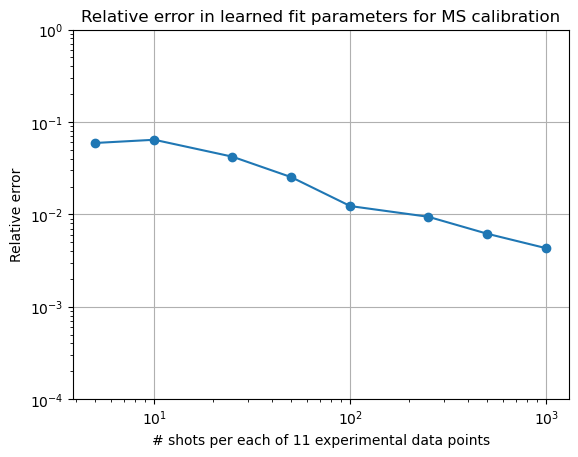

In [4]:
import PyPlot
const plt = PyPlot;

relative_error_means = []
for n_shots in n_shots_list
    push!(relative_error_means, mean(relative_error_results[n_shots]))
end

plt.figure()
plt.plot(n_shots_list, relative_error_means, "-", marker="o")

plt.title("Relative error in learned fit parameters for MS calibration")
plt.ylim(1e-4, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# shots per each of $(length(tspan_experiment)) experimental data points")
plt.ylabel("Relative error")
plt.grid();

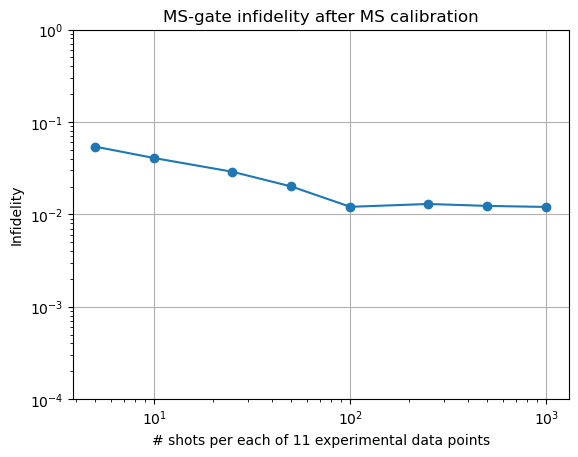

In [5]:
import PyPlot
const plt = PyPlot;

fidelity_means = []
for n_shots in n_shots_list
    push!(fidelity_means, mean(fidelities[n_shots]))
end

plt.figure()
plt.plot(n_shots_list, 1 .- fidelity_means, "-", marker="o")

plt.title("MS-gate infidelity after MS calibration")
plt.ylim(1e-4, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# shots per each of $(length(tspan_experiment)) experimental data points")
plt.ylabel("Infidelity")
plt.grid();

## Print the raw result data

In [6]:
print(relative_error_results)

Dict{Any, Any}(5 => Any[0.012527697165611312, 0.04736574014268058, 0.011221740025829484, 0.031019847522327525, 0.03337771838303644, 0.1625231721011108, 0.1609582140624933, 0.04927136165545841, 0.15619697565882587, 0.06678462999411036, 0.11428476165543287, 0.003558835504495153, 0.12524349764981216, 0.09163489473020565, 0.015317031242845879, 0.008084186394732608, 0.04610303955496913, 0.01873001851183601, 0.006925925938932617, 0.022675294448919955], 50 => Any[0.0046529680364637204, 0.02648470867927381, 0.003803590499549025, 0.02726501984135278, 0.025962673709576153, 0.031078661419656418, 0.02423092605827597, 0.00456586693705534, 0.0004341325794422726, 0.027015608514873907, 0.01937309440851853, 0.02284353925723894, 0.02211583080664583, 0.010128717968909537, 0.009647206914352469, 0.01631380256506219, 0.004221330546648702, 0.011906049618253856, 0.03339115661384313, 0.17933692584057212], 500 => Any[0.007134897262063012, 0.00840993257828333, 0.00672346409750958, 0.008078440051613124, 0.0018240

In [7]:
print(fidelities)

Dict{Any, Any}(5 => Any[0.9748967483392356, 0.9823096838252081, 0.9866861769145095, 0.983311071726539, 0.9955941350750839, 0.8780078888302556, 0.906674946695178, 0.9663007807718045, 0.901449861639955, 0.9607307250893886, 0.9342270001708319, 0.9880564959176342, 0.9212964011743301, 0.9453047567644097, 0.7012236001183496, 0.9723904327370039, 0.986758222497361, 0.984050869651958, 0.9762838625706844, 0.9748338393619154], 50 => Any[0.9971073078833911, 0.9759367594328954, 0.9872713753443354, 0.974575946648057, 0.9915267652681552, 0.9752229592474584, 0.9870580212034019, 0.9977502269618791, 0.9971762899835149, 0.9757886940949978, 0.9902066085270136, 0.985304189479467, 0.9739685855028627, 0.997455684496324, 0.9968729347503029, 0.9835159076732521, 0.9941725342928677, 0.9746683570262558, 0.9727352236219945, 0.8711550534841381], 500 => Any[0.9802383482300796, 0.9857162385320195, 0.9813638398117344, 0.9808373322426336, 0.9834343633704274, 0.9973314536825665, 0.9991724370019801, 0.9864958051642153, 0